In [1]:
!pip install opencv-python-headless==4.10.0.84
!pip install pandas==2.2.3
!pip install -U scikit-learn==1.5.2
!pip install albumentations==1.4.18
!pip install segmentation-models-pytorch
!pip install timm

In [2]:
# =========================
# 1. 라이브러리 임포트 및 설정
# =========================
# python native
import os
import timm
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
import albumentations as A
from albumentations.pytorch import ToTensorV2

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models


# segmentation_models_pytorch
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss, FocalLoss

# visualization
import matplotlib.pyplot as plt
from glob import glob

# ?
from skimage.measure import label

# [핵심 설정]
# 원본 해상도(2048)를 유지하되, 학습 시에는 1024 크기로 잘라서 학습하여
# 미세한 뼈의 디테일을 살리고 GPU 메모리를 아낍니다.
ORIGINAL_SIZE = 2048
PATCH_SIZE = 1024 
BATCH_SIZE = 2  # 1024 패치를 쓰면 배치를 좀 더 키울 수 있습니다 (기존 2048 학습시보다)

/data/ephemeral/home/py310/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# =========================
# 2. 데이터 증강(Augmentation) 파이프라인 정의
# =========================
# [설정] 이미지 크기 및 패치 크기: 학습 시 2048 원본에서 1024 크기의 영역을 무작위로 잘라 학습
CROP_SIZE = 1024

# -----------------------------------------------------------------------------
# 1. 학습용 증강 (Train Transform): 기하학적 변형과 픽셀 강도 변형을 조합하여 데이터 다양성 확보
# -----------------------------------------------------------------------------
train_transform = A.Compose([
    # [1] 공간/형태 변형 (Spatial Augmentation): 2048x2048 이미지에서 1024x1024 크기를 무작위로 추출
    A.RandomCrop(height=CROP_SIZE, width=CROP_SIZE, always_apply=True),
    
    # 50% 확률로 좌우 반전 (손 뼈는 대칭적 특성이 있어 매우 효과적)
    A.HorizontalFlip(p=0.5),
    
    # 회전, 크기 조절, 이동 (뼈의 위치와 각도 변화 대응)
    A.ShiftScaleRotate(
        shift_limit=0.0625, 
        scale_limit=0.1, 
        rotate_limit=45, 
        p=0.5
    ),
    
    # [중요] 형태학적 왜곡 (Distortion) - 뼈의 기형이나 환자별 손 모양의 미세한 차이를 모사하기 위해 비선형 왜곡 적용
    A.OneOf([
        A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
        A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
        A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
    ], p=0.3),

    # [2] 픽셀/화질 변형 (Pixel-level Augmentation) - CLAHE: X-ray 이미지에서 뼈의 윤곽(대비)를 뚜렷하게 만듦
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),
    
    # 밝기 및 대비 조절 (촬영 장비별 노출 차이 대응)
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    
    # 약간의 노이즈 추가 및 블러링 (화질 저하 대응) - GaussNoise: 노이즈 추가, GaussianBlur: 흐림 효과 (화질 저하 모사)
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
        A.GaussianBlur(blur_limit=(3, 7), p=1.0),
        A.MotionBlur(blur_limit=3, p=1.0)
    ], p=0.2),

    # [3] 정규화 및 텐서 변환 : ImageNet Pretrained 모델을 사용하므로 해당 통계값으로 정규화
    A.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    ),
    ToTensorV2()
])

# -----------------------------------------------------------------------------
# 2. 검증/추론용 변환 (Validation/Test Transform): 학습된 모델 평가를 위해 이미지를 왜곡하지 않고 정규화만 수행
# -----------------------------------------------------------------------------
val_transform = A.Compose([     # 학습 데이터와 동일한 통계값 사용
    A.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    ),
    ToTensorV2()
])

print("Augmentation pipeline defined successfully.")

Augmentation pipeline defined successfully.


/tmp/ipykernel_573886/55996888.py:29: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)


In [4]:
# =========================
# 3. JSON 마스크 변환 및 데이터셋 클래스 정의
# =========================
# 클래스 매핑 (대회 정보 기반)
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}

class XRayDataset(Dataset):
    def __init__(self, image_root, label_root=None, mode='train', transform=None):
        self.mode = mode
        self.transform = transform
        self.image_paths = sorted(glob(os.path.join(image_root, '*', '*.png')))
        self.label_root = label_root

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        # 이미지 로드
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.mode in ['train', 'val']:
            # 라벨 로드 (JSON -> Mask 변환)
            folder_name = img_path.split(os.sep)[-2]
            file_name = img_path.split(os.sep)[-1].replace('.png', '.json')
            label_path = os.path.join(self.label_root, folder_name, file_name)
            
            # 마스크 생성
            mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
            
            with open(label_path, 'r') as f:
                annotations = json.load(f)['annotations']
            
            for ann in annotations:
                class_name = ann['label']
                points = np.array(ann['points'], dtype=np.int32)
                class_id = CLASS2IND[class_name] + 1
                cv2.fillPoly(mask, [points], class_id)
            
            # [수정된 부분] 여기서 transform을 적용해야 합니다!
            # 이미지와 마스크를 함께 변형(Crop, Flip 등)시킵니다.
            if self.transform:
                augmented = self.transform(image=img, mask=mask)
                img = augmented['image']
                mask = augmented['mask']
            
            # 마스크 타입 보장 (int64/long)
            # ToTensorV2가 마스크를 Tensor로 안 바꿨을 경우를 대비
            if not isinstance(mask, torch.Tensor):
                mask = torch.tensor(mask, dtype=torch.long)
            else:
                mask = mask.long()

            return img, mask
        
        else: # Test 모드
            if self.transform:
                augmented = self.transform(image=img)
                img = augmented['image']
            return img, img_path # Test셋은 경로 반환 필요

Total Train Images: 800


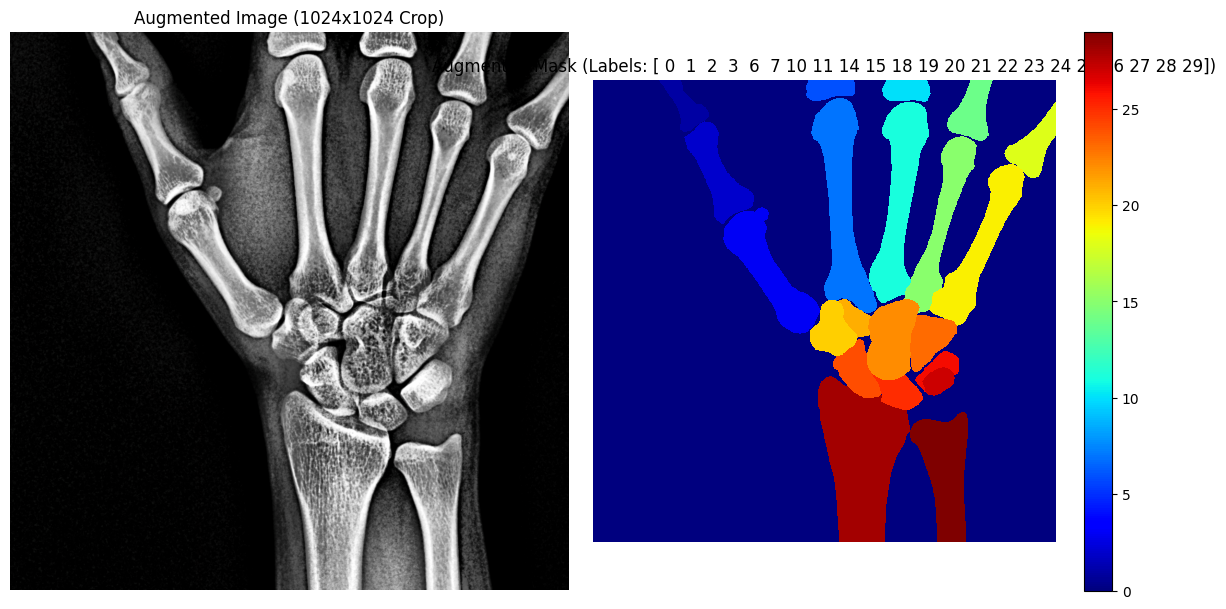

In [5]:
# =========================
# 4. 데이터 로더 생성 및 시각화
# =========================
# 경로 설정 (사용자 서버 경로)
TRAIN_IMG_ROOT = '/data/ephemeral/home/data/train/DCM'
TRAIN_LABEL_ROOT = '/data/ephemeral/home/data/train/outputs_json'

# 데이터셋 인스턴스 생성
train_dataset = XRayDataset(
    image_root=TRAIN_IMG_ROOT, 
    label_root=TRAIN_LABEL_ROOT, 
    mode='train', 
    transform=train_transform
)

# 시각화 함수
def visualize_augmentations(dataset, idx=0):
    image, mask = dataset[idx]
    
    # 1) 이미지 처리 (Tensor -> List -> Numpy 우회 변환)
    if isinstance(image, torch.Tensor):
        # 1. CPU로 이동 후 Python List로 변환 (.tolist()는 Numpy를 안 씁니다)
        image_list = image.permute(1, 2, 0).detach().cpu().tolist()
        # 2. Python List를 Numpy로 변환
        image_np = np.array(image_list)
    else:
        image_np = image.copy()


    # 2) 정규화(Normalize) 역변환 (시각화용)
    # float 타입인지 확인
    if image_np.dtype == np.float32 or image_np.dtype == np.float64:
        if image_np.max() <= 5.0: 
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image_np = (image_np * std) + mean
            image_np = np.clip(image_np, 0, 1)


    # 3) 마스크 처리 (Tensor -> List -> Numpy 우회 변환)
    if isinstance(mask, torch.Tensor):
        # 1. CPU로 이동 후 Python List로 변환
        mask_list = mask.detach().cpu().tolist()
        # 2. Python List를 Numpy로 변환 (타입은 uint8로 고정 추천)
        mask = np.array(mask_list, dtype=np.uint8)

    # 4) 시각화 출력
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title("Augmented Image (1024x1024 Crop)")
    plt.imshow(image_np)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    # 마스크 레이블 확인
    unique_labels = np.unique(mask)
    plt.title(f"Augmented Mask (Labels: {unique_labels})")
    
    # 마스크 시각화 (0=배경, 1~29=뼈)
    plt.imshow(mask, cmap='jet', interpolation='nearest', vmin=0, vmax=29)
    plt.colorbar()
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# 실행하여 확인
print(f"Total Train Images: {len(train_dataset)}")
visualize_augmentations(train_dataset, idx=0) # 0번째 이미지 확인

In [6]:
# =========================
# 4-1. 데이터셋 분리 및 로더 생성
# =========================
# 전체 데이터셋 크기 확인 (임시 인스턴스 생성으로 크기 확인)
temp_dataset = XRayDataset(image_root=TRAIN_IMG_ROOT, label_root=TRAIN_LABEL_ROOT, mode='train', transform=train_transform)
dataset_size = len(temp_dataset)
val_size = int(dataset_size * 0.1)
train_size = dataset_size - val_size

# (안전한 방법) - 여기서 root -> image_root 로 수정했습니다.
train_dataset = XRayDataset(image_root=TRAIN_IMG_ROOT, label_root=TRAIN_LABEL_ROOT, mode='train', transform=train_transform)
val_dataset = XRayDataset(image_root=TRAIN_IMG_ROOT, label_root=TRAIN_LABEL_ROOT, mode='val', transform=val_transform)

# 인덱스로 분리 (검증 데이터 고정을 위해 시드 고정 권장)
indices = list(range(len(train_dataset)))
np.random.shuffle(indices)

train_indices = indices[val_size:]
val_indices = indices[:val_size]

train_subset = torch.utils.data.Subset(train_dataset, train_indices)
val_subset = torch.utils.data.Subset(val_dataset, val_indices)

# DataLoader 정의
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print(f"Train Size: {len(train_subset)}, Val Size: {len(val_subset)}")

Train Size: 720, Val Size: 80


In [7]:
# =========================
# 5. 모델 아키텍처 정의 (U-Net + HRNetV2-W48)
# =========================
# 클래스 수 계산 (배경 0 + 뼈 29개 = 30)
NUM_CLASSES = len(CLASSES) + 1 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def build_model():
    """
    HRNet-W48을 백본으로 사용하는 U-Net 모델 생성
    - 입력 크기가 1024x1024로 크기 때문에 VRAM 관리가 중요합니다.
    """
    model = smp.Unet(
        # [백본 설정]
        # tu-hrnet_w48: 성능은 최고지만 무거움. 
        # OOM 발생 시: 'tu-hrnet_w32' -> 'tu-hrnet_w18' -> 'efficientnet-b4' 순으로 변경 권장
        encoder_name="tu-hrnet_w32", 
        
        # [가중치] ImageNet 사전 학습 가중치 사용
        encoder_weights="imagenet", 
        
        # [입출력 설정]
        in_channels=3,
        classes=NUM_CLASSES,
    )
    return model

# 모델 생성
model = build_model()
model.to(device)

print(f"✅ Model built successfully using HRNet-W48 backbone.")
print(f"✅ Target Output Channels: {NUM_CLASSES} (Background + 29 Bones)")
print(f"✅ Device: {device}")

# ----------------------------------------------------
# [중요] 메모리 확인 팁
# ----------------------------------------------------
if torch.cuda.is_available():
    # 현재 할당된 메모리 확인 (GB 단위)
    print(f"🔹 Current GPU Memory Allocated: {torch.cuda.memory_allocated(device) / 1024**3:.2f} GB")
    print("⚠️ If you encounter 'CUDA out of memory', reduce 'BATCH_SIZE' or change 'encoder_name'.")

Unexpected keys (downsamp_modules.0.1.num_batches_tracked, downsamp_modules.1.1.num_batches_tracked, downsamp_modules.2.1.num_batches_tracked, final_layer.1.num_batches_tracked, downsamp_modules.0.0.bias, downsamp_modules.0.0.weight, downsamp_modules.0.1.bias, downsamp_modules.0.1.running_mean, downsamp_modules.0.1.running_var, downsamp_modules.0.1.weight, downsamp_modules.1.0.bias, downsamp_modules.1.0.weight, downsamp_modules.1.1.bias, downsamp_modules.1.1.running_mean, downsamp_modules.1.1.running_var, downsamp_modules.1.1.weight, downsamp_modules.2.0.bias, downsamp_modules.2.0.weight, downsamp_modules.2.1.bias, downsamp_modules.2.1.running_mean, downsamp_modules.2.1.running_var, downsamp_modules.2.1.weight, final_layer.0.bias, final_layer.0.weight, final_layer.1.bias, final_layer.1.running_mean, final_layer.1.running_var, final_layer.1.weight, classifier.bias, classifier.weight) found while loading pretrained weights. This may be expected if model is being adapted.


✅ Model built successfully using HRNet-W48 backbone.
✅ Target Output Channels: 30 (Background + 29 Bones)
✅ Device: cuda
🔹 Current GPU Memory Allocated: 0.14 GB
⚠️ If you encounter 'CUDA out of memory', reduce 'BATCH_SIZE' or change 'encoder_name'.


In [9]:
# =========================
# 6. 손실 함수 및 학습 루프
# =========================
# 하이퍼파라미터
LR = 1e-4                 # 학습률 (HRNet 등 무거운 모델은 너무 크지 않게 시작)
EPOCHS = 50               # 전체 학습 에폭 수
LOG_INTERVAL = 10         # 로그 출력 간격 (Step 단위)
VAL_INTERVAL = 1          # 검증 간격 (Epoch 단위)
      

# 1) 손실 함수 정의 (Dice + Focal -> Lovasz Fine-tuning)
class HandBoneLoss(nn.Module):
    def __init__(self, mode='base'):
        super(HandBoneLoss, self).__init__()
        self.mode = mode
        self.dice_loss = smp.losses.DiceLoss(mode='multiclass', from_logits=True)
        self.focal_loss = smp.losses.FocalLoss(mode='multiclass') 
        # [추가됨] Lovasz Loss
        self.lovasz_loss = smp.losses.LovaszLoss(mode='multiclass', from_logits=True)
        
    def forward(self, logits, targets):
        if self.mode == 'base':
            # 초기 학습용: Dice + Focal
            return self.dice_loss(logits, targets) + self.focal_loss(logits, targets)
        elif self.mode == 'finetune':
            # 후반 튜닝용: Lovasz + (선택적으로 Dice 유지)
            # Lovasz 단독 사용보다 Dice와 섞는 것이 더 안정적인 경우가 많음 (0.5:0.5 추천)
            return 0.5 * self.lovasz_loss(logits, targets) + 0.5 * self.dice_loss(logits, targets)

# 두 가지 버전의 손실 함수 인스턴스 생성
criterion_base = HandBoneLoss(mode='base').to(device)
criterion_finetune = HandBoneLoss(mode='finetune').to(device)


# 2) 최적화 도구
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-3)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

# Mixed Precision (AMP) 설정을 위한 Scaler (HRNet 필수)
scaler = torch.cuda.amp.GradScaler()

# 3) 평가 지표 함수 (간이 Dice 계산 수정)
def compute_dice_score(outputs, masks, num_classes=30):
    # outputs: (B, C, H, W), masks: (B, H, W)
    # Argmax로 예측 클래스 맵 생성
    preds = torch.argmax(outputs, dim=1)
    
    dice_score = 0.0
    # 배경(0)을 제외하고 뼈(1~29)에 대해서만 평균을 낼 수도 있음. 여기선 전체 평균.
    for cls in range(num_classes):
        input_mask = (preds == cls).float()
        target_mask = (masks == cls).float()
        
        intersection = (input_mask * target_mask).sum()
        union = input_mask.sum() + target_mask.sum() + 1e-8 # 0 나누기 방지
        
        dice_score += (2. * intersection) / union
        
    return dice_score / num_classes

# 4) 학습 루프 (Training Loop) - AMP 적용
def train_one_epoch(loader, model, criterion, optimizer, scaler, epoch):
    model.train()
    running_loss = 0.0
    
    pbar = tqdm(enumerate(loader), total=len(loader), desc=f"Epoch {epoch} Train")
    
    for step, (images, masks) in pbar:
        images = images.to(device)
        masks = masks.long().to(device)
        
        optimizer.zero_grad()
        
        # [AMP] autocast로 연산 정밀도 자동 조절 (메모리 절약)
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, masks)
        
        # [AMP] Scaler를 통해 Backward 수행
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        
        if (step + 1) % LOG_INTERVAL == 0:
            pbar.set_postfix({'Loss': running_loss / (step + 1)})
    
    return running_loss / len(loader)

# 검증 루프 (Validation Loop)
def validate(loader, model, criterion, epoch):
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    
    with torch.no_grad():
        pbar = tqdm(enumerate(loader), total=len(loader), desc=f"Epoch {epoch} Val")
        for step, (images, masks) in pbar:
            images = images.to(device)
            masks = masks.long().to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            val_loss += loss.item()
            
            # Dice Score 계산 (CPU 부하를 줄이기 위해 검증 때만 계산 권장)
            dice = compute_dice_score(outputs, masks, num_classes=NUM_CLASSES)
            val_dice += dice.item()
            
            pbar.set_postfix({'Val Loss': val_loss / (step + 1), 'Dice': val_dice / (step + 1)})
            
    return val_loss / len(loader), val_dice / len(loader)

# 5) 실행 (Main Execution)
best_val_loss = float('inf')
save_dir = './checkpoints'
import os
os.makedirs(save_dir, exist_ok=True)

print(f"Start Training on {device} with AMP...")


# [전략 설정] 언제부터 Lovasz로 갈아탈 것인가?
LOVASZ_START_EPOCH = 35  # 전체 50 에폭 중 후반 15 에폭 동안 미세 조정

for epoch in range(1, EPOCHS + 1):
    # 에폭에 따라 손실 함수 교체
    if epoch >= LOVASZ_START_EPOCH:
        current_criterion = criterion_finetune
        if epoch == LOVASZ_START_EPOCH:
            print(f"🚀 [Strategy Change] Switch Loss Function to Lovasz Loss for Fine-tuning!")
    else:
        current_criterion = criterion_base

    # Train (criterion 인자 변경)
    train_loss = train_one_epoch(train_loader, model, current_criterion, optimizer, scaler, epoch)
    
    # Validation
    if epoch % VAL_INTERVAL == 0:
        val_loss, val_dice = validate(val_loader, model, current_criterion, epoch) # val_loader가 정의되어 있어야 함
        
        # Scheduler Step (Validation Loss 기준이 아니라 Epoch 기준이면 여기 둠)
        scheduler.step()
        
        print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f}")
        
        # Save Best Model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"{save_dir}/best_model.pth")
            print(f"🌟 Best model saved at epoch {epoch} (Val Loss: {val_loss:.4f})")

print("Training Finished.")

Start Training on cuda with AMP...


Epoch 1 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 1 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 0.9845 | Val Loss: 0.8787 | Val Dice: 0.3814
🌟 Best model saved at epoch 1 (Val Loss: 0.8787)


Epoch 2 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 2 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 0.6751 | Val Loss: 0.6316 | Val Dice: 0.6039
🌟 Best model saved at epoch 2 (Val Loss: 0.6316)


Epoch 3 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 3 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 0.4683 | Val Loss: 0.4498 | Val Dice: 0.6973
🌟 Best model saved at epoch 3 (Val Loss: 0.4498)


Epoch 4 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 4 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 0.3621 | Val Loss: 0.3382 | Val Dice: 0.7700
🌟 Best model saved at epoch 4 (Val Loss: 0.3382)


Epoch 5 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 5 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 0.2832 | Val Loss: 0.2476 | Val Dice: 0.8252
🌟 Best model saved at epoch 5 (Val Loss: 0.2476)


Epoch 6 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 6 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6 | Train Loss: 0.2384 | Val Loss: 0.1976 | Val Dice: 0.8866
🌟 Best model saved at epoch 6 (Val Loss: 0.1976)


Epoch 7 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 7 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7 | Train Loss: 0.2030 | Val Loss: 0.1813 | Val Dice: 0.8918
🌟 Best model saved at epoch 7 (Val Loss: 0.1813)


Epoch 8 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 8 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8 | Train Loss: 0.1906 | Val Loss: 0.1527 | Val Dice: 0.9094
🌟 Best model saved at epoch 8 (Val Loss: 0.1527)


Epoch 9 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 9 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9 | Train Loss: 0.1718 | Val Loss: 0.1439 | Val Dice: 0.9348
🌟 Best model saved at epoch 9 (Val Loss: 0.1439)


Epoch 10 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 10 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.1646 | Val Loss: 0.1397 | Val Dice: 0.9346
🌟 Best model saved at epoch 10 (Val Loss: 0.1397)


Epoch 11 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 11 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 0.2335 | Val Loss: 0.1483 | Val Dice: 0.9184


Epoch 12 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 12 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12 | Train Loss: 0.1813 | Val Loss: 0.1108 | Val Dice: 0.9295
🌟 Best model saved at epoch 12 (Val Loss: 0.1108)


Epoch 13 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 13 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13 | Train Loss: 0.1635 | Val Loss: 0.0971 | Val Dice: 0.9391
🌟 Best model saved at epoch 13 (Val Loss: 0.0971)


Epoch 14 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 14 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14 | Train Loss: 0.1627 | Val Loss: 0.0939 | Val Dice: 0.9377
🌟 Best model saved at epoch 14 (Val Loss: 0.0939)


Epoch 15 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 15 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15 | Train Loss: 0.1401 | Val Loss: 0.0872 | Val Dice: 0.9400
🌟 Best model saved at epoch 15 (Val Loss: 0.0872)


Epoch 16 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 16 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16 | Train Loss: 0.1328 | Val Loss: 0.0818 | Val Dice: 0.9431
🌟 Best model saved at epoch 16 (Val Loss: 0.0818)


Epoch 17 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 17 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17 | Train Loss: 0.1230 | Val Loss: 0.1122 | Val Dice: 0.9182


Epoch 18 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 18 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18 | Train Loss: 0.1256 | Val Loss: 0.0814 | Val Dice: 0.9429
🌟 Best model saved at epoch 18 (Val Loss: 0.0814)


Epoch 19 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 19 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19 | Train Loss: 0.1174 | Val Loss: 0.0781 | Val Dice: 0.9446
🌟 Best model saved at epoch 19 (Val Loss: 0.0781)


Epoch 20 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 20 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20 | Train Loss: 0.1162 | Val Loss: 0.0794 | Val Dice: 0.9440


Epoch 21 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 21 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 21 | Train Loss: 0.1094 | Val Loss: 0.0708 | Val Dice: 0.9476
🌟 Best model saved at epoch 21 (Val Loss: 0.0708)


Epoch 22 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 22 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 22 | Train Loss: 0.1027 | Val Loss: 0.0703 | Val Dice: 0.9480
🌟 Best model saved at epoch 22 (Val Loss: 0.0703)


Epoch 23 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 23 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 23 | Train Loss: 0.1040 | Val Loss: 0.0702 | Val Dice: 0.9478
🌟 Best model saved at epoch 23 (Val Loss: 0.0702)


Epoch 24 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 24 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 24 | Train Loss: 0.1037 | Val Loss: 0.0702 | Val Dice: 0.9486


Epoch 25 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 25 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 25 | Train Loss: 0.0999 | Val Loss: 0.0687 | Val Dice: 0.9488
🌟 Best model saved at epoch 25 (Val Loss: 0.0687)


Epoch 26 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 26 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 26 | Train Loss: 0.0917 | Val Loss: 0.0688 | Val Dice: 0.9486


Epoch 27 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 27 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 27 | Train Loss: 0.0913 | Val Loss: 0.0693 | Val Dice: 0.9483


Epoch 28 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 28 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 28 | Train Loss: 0.0923 | Val Loss: 0.0681 | Val Dice: 0.9494
🌟 Best model saved at epoch 28 (Val Loss: 0.0681)


Epoch 29 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 29 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 29 | Train Loss: 0.0907 | Val Loss: 0.0671 | Val Dice: 0.9498
🌟 Best model saved at epoch 29 (Val Loss: 0.0671)


Epoch 30 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 30 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 30 | Train Loss: 0.0908 | Val Loss: 0.0670 | Val Dice: 0.9498
🌟 Best model saved at epoch 30 (Val Loss: 0.0670)


Epoch 31 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 31 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 31 | Train Loss: 0.1479 | Val Loss: 0.1195 | Val Dice: 0.9113


Epoch 32 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 32 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 32 | Train Loss: 0.1267 | Val Loss: 0.0812 | Val Dice: 0.9402


Epoch 33 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 33 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 33 | Train Loss: 0.1257 | Val Loss: 0.0734 | Val Dice: 0.9442


Epoch 34 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 34 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 34 | Train Loss: 0.1198 | Val Loss: 0.0803 | Val Dice: 0.9406
🚀 [Strategy Change] Switch Loss Function to Lovasz Loss for Fine-tuning!


Epoch 35 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 35 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 35 | Train Loss: 0.1034 | Val Loss: 0.0737 | Val Dice: 0.9474


Epoch 36 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 36 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 36 | Train Loss: 0.0964 | Val Loss: 0.0733 | Val Dice: 0.9467


Epoch 37 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 37 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 37 | Train Loss: 0.1036 | Val Loss: 0.0905 | Val Dice: 0.9338


Epoch 38 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 38 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 38 | Train Loss: 0.1000 | Val Loss: 0.0758 | Val Dice: 0.9449


Epoch 39 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 39 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 39 | Train Loss: 0.0978 | Val Loss: 0.0784 | Val Dice: 0.9422


Epoch 40 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 40 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 40 | Train Loss: 0.0930 | Val Loss: 0.0705 | Val Dice: 0.9481


Epoch 41 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 41 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 41 | Train Loss: 0.0932 | Val Loss: 0.0733 | Val Dice: 0.9460


Epoch 42 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 42 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 42 | Train Loss: 0.0932 | Val Loss: 0.1025 | Val Dice: 0.9196


Epoch 43 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 43 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 43 | Train Loss: 0.0935 | Val Loss: 0.0697 | Val Dice: 0.9486


Epoch 44 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 44 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 44 | Train Loss: 0.0910 | Val Loss: 0.0732 | Val Dice: 0.9459


Epoch 45 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 45 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 45 | Train Loss: 0.0884 | Val Loss: 0.0696 | Val Dice: 0.9484


Epoch 46 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 46 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 46 | Train Loss: 0.0895 | Val Loss: 0.0706 | Val Dice: 0.9475


Epoch 47 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 47 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 47 | Train Loss: 0.0937 | Val Loss: 0.0722 | Val Dice: 0.9466


Epoch 48 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 48 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 48 | Train Loss: 0.0874 | Val Loss: 0.0671 | Val Dice: 0.9502


Epoch 49 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 49 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 49 | Train Loss: 0.0872 | Val Loss: 0.0675 | Val Dice: 0.9496


Epoch 50 Train:   0%|          | 0/360 [00:00<?, ?it/s]

Epoch 50 Val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 50 | Train Loss: 0.0845 | Val Loss: 0.0678 | Val Dice: 0.9494
Training Finished.


In [10]:
# =========================
# 7. 추론 및 제출 파일 생성(Inference & Submission)
# =========================
# [설정] 하이퍼파라미터 및 경로
TEST_IMG_ROOT = '/data/ephemeral/home/data/test/DCM'
CHECKPOINT_PATH = '/data/ephemeral/home/code/checkpoints/best_model.pth'
OUTPUT_CSV_PATH = '/data/ephemeral/home/output/U-Net_HRNetV2-W32.csv'

WINDOW_SIZE = 1024      # 학습 시 사용한 패치 크기
STRIDE = 512            # 슬라이딩 윈도우 이동 간격 (겹치는 구간을 만들어 경계선 예측 보정)
BATCH_SIZE = 2          # GPU 메모리에 맞춰 조절


# 1) RLE 인코딩 함수 (제출용)
def encode_mask_to_rle(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


# 2) LCC 후처리 함수 (노이즈 제거)
def keep_largest_component(mask):
    """
    각 뼈 클래스별로 가장 큰 연결 요소(덩어리)만 남기고 나머지 노이즈는 제거합니다.
    뼈는 해부학적으로 한 덩어리로 존재하기 때문에 성능 향상에 매우 효과적입니다.
    """
    cleaned_mask = np.zeros_like(mask)
    
    # 1번부터 29번 클래스까지 반복 (0은 배경)
    for c in range(1, 30):
        class_mask = (mask == c).astype(np.uint8)
        
        if class_mask.sum() == 0:
            continue
            
        # 연결된 성분 라벨링
        labels, num_features = label(class_mask, background=0, return_num=True, connectivity=2)
        
        if num_features > 0:
            # 가장 큰 영역 찾기 (0번은 배경이므로 제외하고 카운트)
            counts = np.bincount(labels.flat)
            if len(counts) > 1:
                largest_label = np.argmax(counts[1:]) + 1
                cleaned_mask[labels == largest_label] = c
                
    return cleaned_mask


# 3) Gaussian Window 생성 함수
def get_gaussian_window(window_size, sigma=None):
    if sigma is None:
        sigma = window_size / 2
        
    # 1D Gaussian
    x = np.arange(window_size) - window_size // 2
    g = np.exp(-0.5 * (x / sigma) ** 2)
    
    # 2D Gaussian (Outer product)
    g_2d = np.outer(g, g)
    
    # 정규화 (최댓값 1)
    g_2d /= g_2d.max()
    
    return torch.from_numpy(g_2d).float()


# 4) 슬라이딩 윈도우 추론 함수 (Gaussian Blending 적용)
def sliding_window_inference(model, image_tensor, window_size, stride, num_classes=30):
    model.eval()
    
    _, _, h, w = image_tensor.shape
    
    # 전체 이미지 크기에 맞는 빈 텐서 생성
    output_probs = torch.zeros((1, num_classes, h, w), device=device)
    count_map = torch.zeros((1, num_classes, h, w), device=device)
    
    # Gaussian Window 미리 생성 (GPU로 이동)
    window_weight = get_gaussian_window(window_size).to(device)
    
    # 슬라이딩 윈도우 루프
    for y in range(0, h - window_size + 1, stride):
        for x in range(0, w - window_size + 1, stride):
            patch = image_tensor[:, :, y:y+window_size, x:x+window_size]
            
            with torch.no_grad():
                logits = model(patch)
                probs = F.softmax(logits, dim=1)
            
            # [수정됨] 단순 합산이 아니라 Gaussian Window를 곱해서 누적
            # (1, C, H, W) * (H, W) -> 브로드캐스팅 연산
            output_probs[:, :, y:y+window_size, x:x+window_size] += probs * window_weight
            count_map[:, :, y:y+window_size, x:x+window_size] += window_weight
            
    # 가중 평균 계산 : 0으로 나누는 것을 방지하기 위해 엡실론 추가 가능하나, stride가 적절하면 count_map에 0인 곳이 없음.
    output_probs /= count_map
    
    return output_probs



# 5) 테스트 데이터셋 및 로더
class TestDataset(Dataset):
    def __init__(self, img_root, transform=None):
        self.img_paths = sorted(glob(os.path.join(img_root, '*', '*.png')))
        self.transform = transform
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        path = self.img_paths[idx]
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # 추론 시에는 Normalize만 적용
        if self.transform:
            augmented = self.transform(image=img)
            img = augmented['image']
            
        return img, path

test_dataset = TestDataset(TEST_IMG_ROOT, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False) # 슬라이딩 윈도우를 위해 배치 1 권장


# 6) 메인 추론 루프
print("Loading model...")
# 저장된 모델 가중치 로드
checkpoint = torch.load(CHECKPOINT_PATH)
model.load_state_dict(checkpoint)
model.to(device)

rle_results = []
image_names_list = []
class_names_list = []

print("Start Inference...")
for images, paths in tqdm(test_loader):
    images = images.to(device)
    
    # 6-1) 슬라이딩 윈도우 추론 (2048 -> 1024 패치 -> 2048 복원)
    outputs = sliding_window_inference(model, images, WINDOW_SIZE, STRIDE, NUM_CLASSES)
    
    # 6-2) 결과 변환 (Argmax) : (1, C, H, W) -> (H, W)
    outputs = torch.argmax(outputs, dim=1).squeeze().cpu().numpy().astype(np.uint8)
    
    # 6-3) 후처리 (LCC - Largest Connected Component)
    outputs = keep_largest_component(outputs)
    
    # 6-4) 클래스별 RLE 인코딩
    image_name = os.path.basename(paths[0])
    
    # 6-5) 클래스별 RLE 인코딩 및 리스트 저장
    for class_id, class_name in enumerate(CLASSES):
        # 현재 클래스 마스크 추출
        mask = (outputs == (class_id + 1)).astype(np.uint8)
        
        # RLE 인코딩
        rle = encode_mask_to_rle(mask)
        
        # [핵심 수정] 3개의 리스트에 각각 정보를 담습니다.
        image_names_list.append(image_name)  # 파일명 (예: image_123.png)
        class_names_list.append(class_name)  # 클래스명 (예: finger-1)
        rle_results.append(rle)              # RLE 값


# 7) CSV 저장
df = pd.DataFrame({
    'image_name': image_names_list,
    'class': class_names_list,
    'rle': rle_results
})

df.to_csv(OUTPUT_CSV_PATH, index=False)
print(f"Submission saved to {OUTPUT_CSV_PATH}")
print(f"Columns check: {df.columns.tolist()}")



Loading model...
Start Inference...


  0%|          | 0/288 [00:00<?, ?it/s]

Submission saved to /data/ephemeral/home/output/U-Net_HRNetV2-W32.csv
Columns check: ['image_name', 'class', 'rle']


In [ ]:
# =========================
# 
# =========================
